In [40]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.io.wavfile as wf

from glob import glob
from collections import deque
from zplane import *

# 0. Utils

## 0.1. Plot functions

In [41]:
def simple_plot(samples, x_values= np.array([]), plt_title= "", x_label="", y_label="", display_plot=True, save_name=None, bars : list = [], labels : list = []):
    _ = plt.figure()
    plt.title(plt_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if type(samples) != list :
        samples = [samples]
    if labels != [] and len(labels) != len(samples):
        raise Exception("Label size should be the same as the number of samples")
    
    i = 0
    for sample_data in samples:
        if len(x_values) == 0:
            if labels != []:
                plt.plot(sample_data, label=labels[i])
            else:
                plt.plot(sample_data)
        else:
            if labels != []:
                plt.plot(x_values, sample_data, label=labels[i])
            else:
                plt.plot(x_values, sample_data)
        i += 1
    if labels != []:
        plt.legend(loc="upper right")
    if bars != []:
        for bar in bars:
            # bar = 1
            plt.axvline(bar, color="gray", linestyle="--")
            pass
    if save_name != None:
        plt.savefig(save_name)
    if display_plot:
        plt.show()
    plt.close() 

In [42]:
def plot_create_sin(f, A, fs, N, bars : list = []):
    t, samples = create_sine_wave(f, A, fs, N)
    plot_sin(t, samples, bars)

def plot_sin(t, samples, bars : list = [], title=None):
    if type(t) == type(None):
        t = np.array([])
    simple_plot(samples, t, f"Sine wave" if title == None else title, "Time (sample)" if len(t) == 0 else "Time (s)", "Amplitude (V)", display_plot=True, bars=bars)

def plot_sound_wave(data, file_name: str):
    simple_plot(data, plt_title=f"Sound Wave {file_name}", x_label="Time (sample)", y_label="Amplitude (V)")


def plot_buffer_content(buffer: deque, sample_added: int, recording_time: int):
    sample_text = "sample" if sample_added == 0 else "samples"

    simple_plot(buffer, plt_title=f"Buffer contents after adding {sample_added} {sample_text} (i.e. after {recording_time} s)", 
                x_label= "Stored sample",y_label="Amplitude (s)")


def plot_filter(B_filter, A_filter, fs, name_of_filter):
    w_a, h_a = signal.freqz(B_filter, A_filter, fs= fs)
    plt.figure()
    plt.title(f"Frequency domain of the {name_of_filter} filter")
    plt.xlabel("f (Hz)")
    plt.ylabel("Amplitude (dB)")
    plt.plot(w_a, 20 * np.log10(np.abs(h_a)))
    plt.grid(which="both", axis="both")
    plt.show()
    plt.close()

## 0.2. Variables

In [43]:
wp = 8000
ws = 9000
rp = 0.1
rs = 70

fs_audio = 44.1 * 1000

file_dir = "LocateClaps/"

# 1. Data generation and dataset

## 1.1. Data generation and dataset

### 1.1.1. Sine wave function

In [44]:
def create_sine_wave(f, A, fs, N):
    sampling = np.arange(0, N/fs,1/fs)
    sin_samples =  np.sin(2 * np.pi * sampling * f)
    return sampling, A * sin_samples

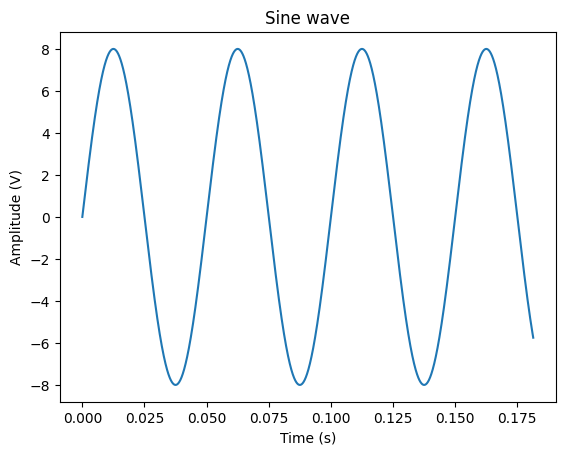

In [45]:
N = 8000

f = 20
amplitude = 8

plot_create_sin(f, amplitude, fs_audio, N)

### 1.1.2 Read Wavefile function

In [46]:
def read_wavefile(path):
    return wf.read(path)

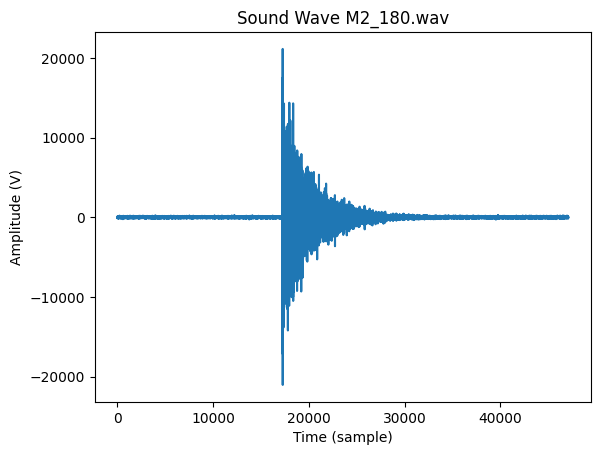

In [47]:
file_name = "M2_180.wav"

f, data1 = read_wavefile(file_dir + file_name)

plot_sound_wave(data1, file_name)

In [48]:
skip_saving = True
SavePlotFile = "SoundWavePlots/"
LocateClaps = "./LocateClaps"
files = glob(f"{LocateClaps}/*.wav")

if not skip_saving:
    for file in files:
        _, data1 = read_wavefile(file)
        file_name = file.removeprefix(LocateClaps + "/").removesuffix(".wav") # keep only the name

        simple_plot(data1, plt_title=f"Sound Wave {file_name}.wav", x_label="Time (s)", y_label="Amplitude (V)", 
                    display_plot=False, save_name=f"{SavePlotFile}/{file_name}")

## 1.2 Buffering

### 1.2.1 Create the `create_ringbuffer` function

In [49]:
def create_ringbuffer(maxlen) -> deque:
    return deque(maxlen=maxlen)

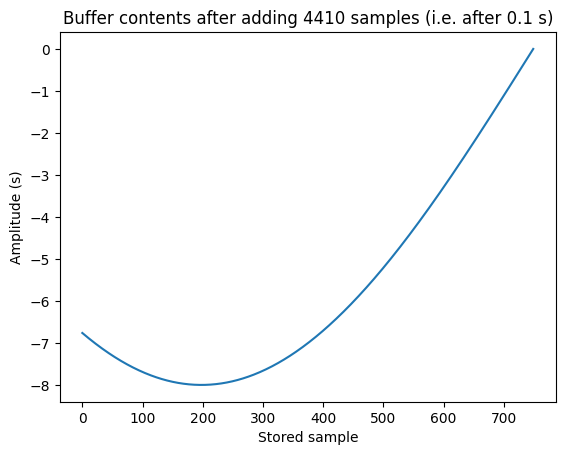

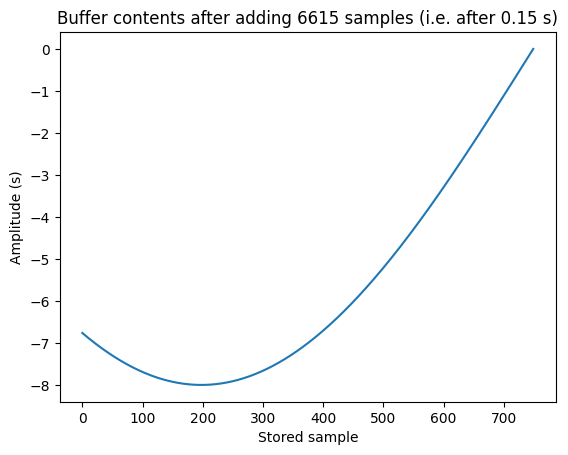

In [50]:

N = 8000

f = 20
amplitude = 8


maxlen = 750
buffer = create_ringbuffer(maxlen)

display_at_times = [0.1, 0.15]

t, samples = create_sine_wave(f, amplitude, fs_audio, N)
for i, sample in enumerate(samples):
    buffer.append(sample)
    for time in display_at_times:
        if i == int(time * fs_audio):
            plot_buffer_content(buffer, i, time)
# When using our signal wave from 1.1.1, and looking at the times 0.1 & 0.01, we notice the exact same waveform.

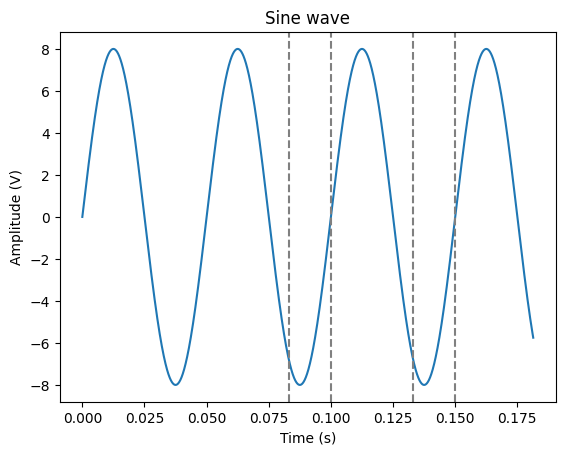

In [51]:

plot_create_sin(f, amplitude, fs_audio, N, bars=[0.1 - (maxlen/ fs_audio) ,0.1, 0.15 - (maxlen/ fs_audio), 0.15])

## 1.3. Pre-processing

#### 1.3.1. Normalisation

In [52]:
def get_max(s):
    max = float('-inf')
    for i in s:
        if i > max:
            max = i
    return max

def normalise(s):
    max = get_max(s)
    return s / max

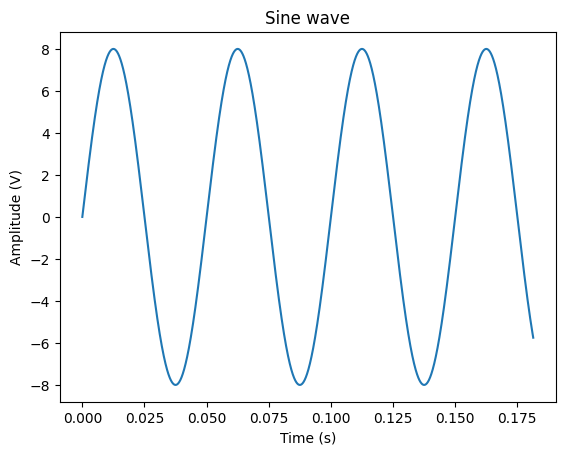

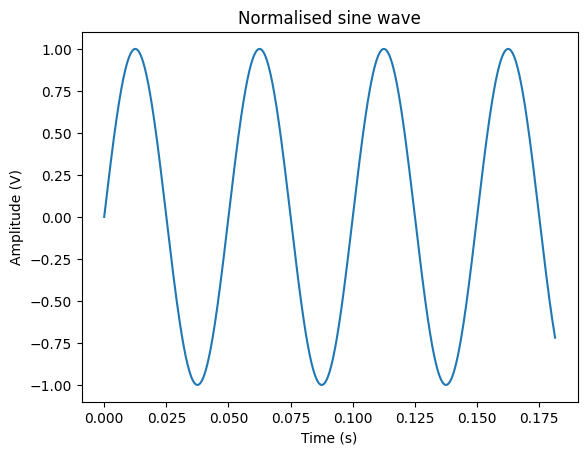

In [53]:
plot_sin(t, samples)
plot_sin(t, normalise(samples), title="Normalised sine wave")

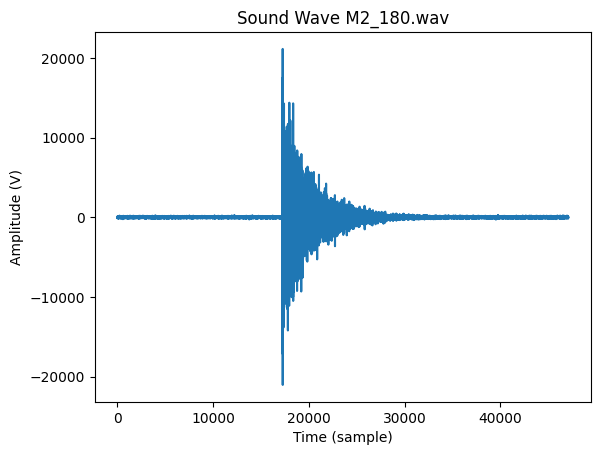

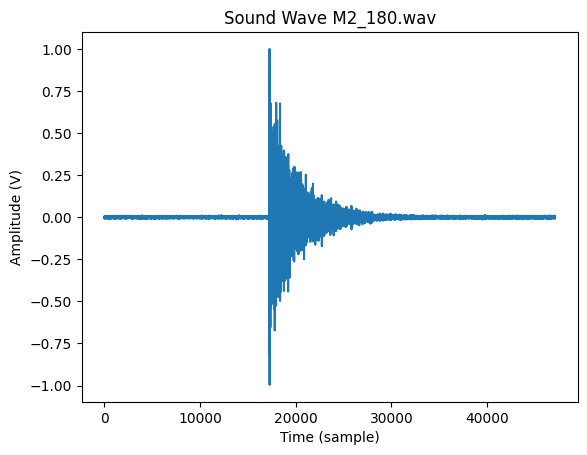

In [54]:
plot_sound_wave(data1, "M2_180.wav")
plot_sound_wave(normalise(data1), "M2_180.wav")

### 1.3.2 Downsampling

#### 1.3.2.1. Signal analysis

Text(0.5, 1.0, 'Spectogram of the file M1_0.wav')

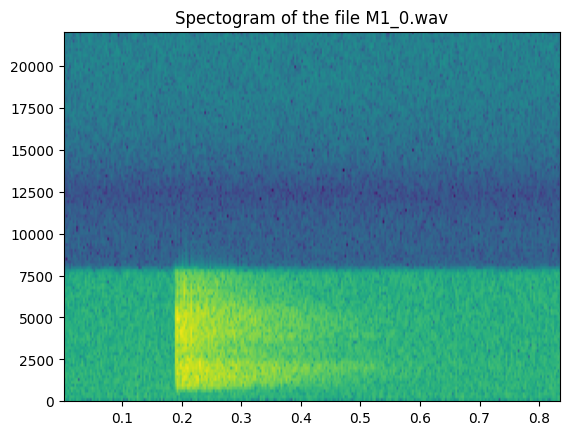

In [55]:
# Using that example, let's do the same for one of the audio file :)
f, data1 = read_wavefile("LocateClaps/M1_0.wav")
x = plt.specgram(normalise(data1), Fs=f)
plt.title("Spectogram of the file M1_0.wav")


#### 1.3.2.2 Anti-aliasing filter

In [56]:
def create_filter_cheby(wp, ws, gpass, gstop, fs):
    N, wn = signal.cheb1ord(wp, ws, gpass, gstop, fs=fs)
    return signal.cheby1(N, gpass, wn, "lowpass", False, fs=fs) # lowpass because we need to filter out frequencies above a certain threshold

def create_filter_cauer(wp, ws, gpass, gstop, fs):
    N, wn = signal.ellipord(wp, ws, gpass, gstop, fs=fs)
    return signal.ellip(N, gpass, gstop, wn, 'lowpass', False, fs=fs) 

In [57]:
(B_caueur, A_caueur) = create_filter_cauer(wp, ws,  rp, rs, 44100)

(B_cheby, A_cheby) = create_filter_cheby(wp, ws,  rp,  rs, 44100)

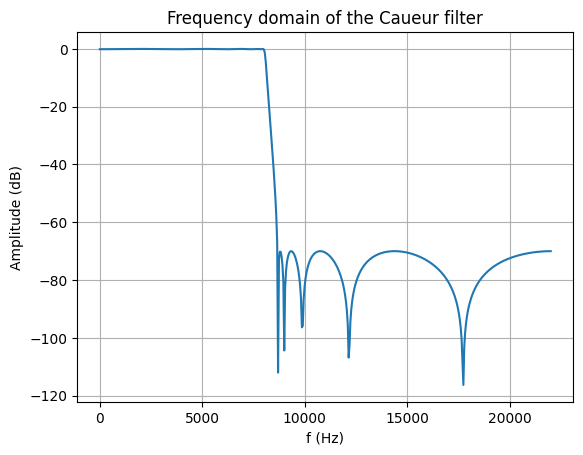

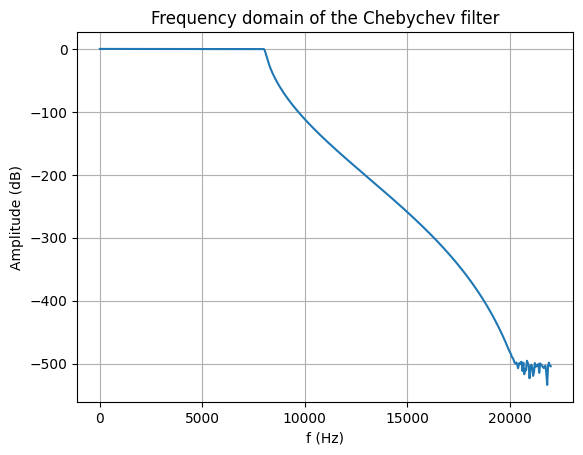

In [58]:
plot_filter(B_caueur, A_caueur, 44100, "Caueur")

plot_filter(B_cheby, A_cheby, 44100, "Chebychev")

##### 1.3.2.2.1 Use it on a signal wave with amplitude 1000V and frequency 8500 Hz and another sine wave with amplitude 20 and frequency 7500 Hz.

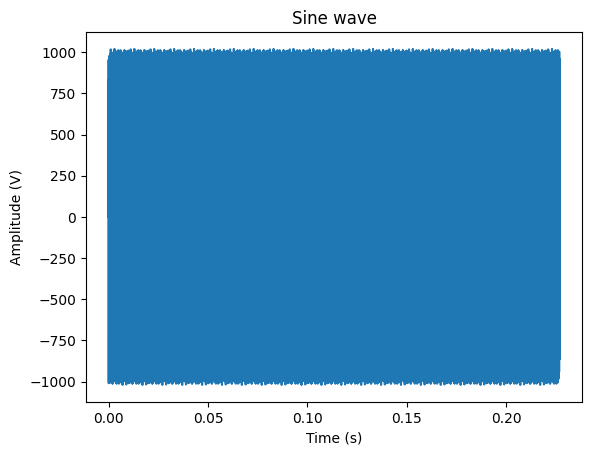

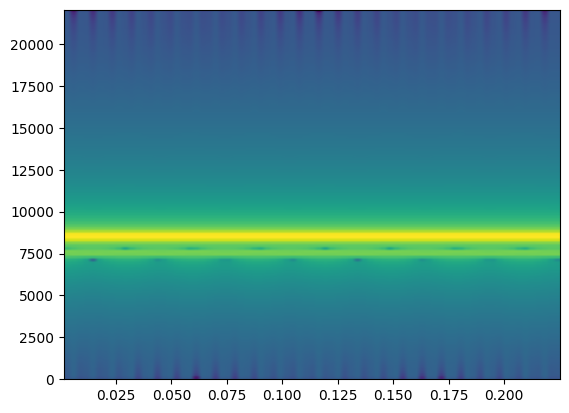

In [59]:
nb_of_samples = 10000

t, sin_samples = create_sine_wave(8500, 1000, fs_audio, nb_of_samples) 
sin_samples += create_sine_wave(7500, 20, fs_audio, nb_of_samples)[1]

plot_sin(t, sin_samples)
x = plt.specgram(sin_samples, Fs=f)

Apply it on the created signal

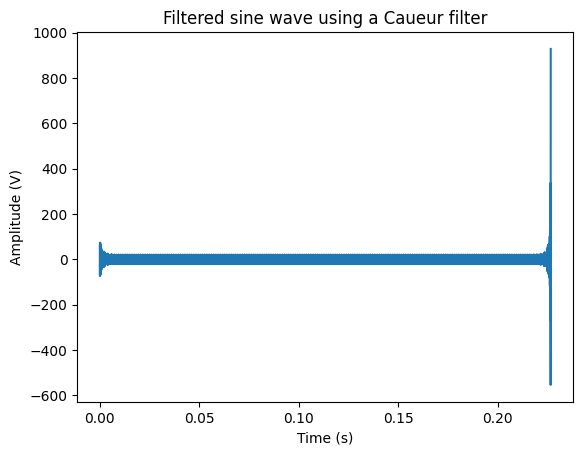

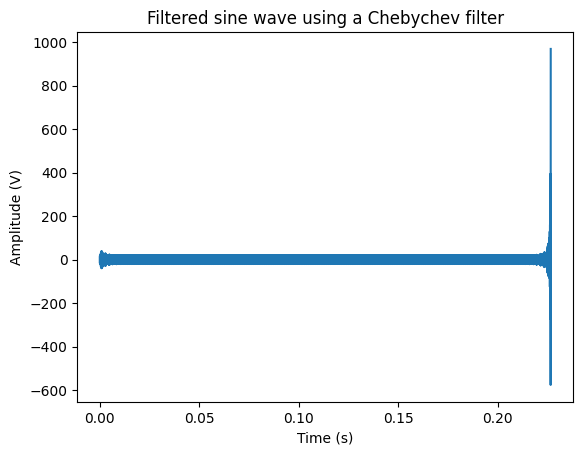

Text(0.5, 1.0, 'Spectogram of the filtered sine wave (using Caueur)')

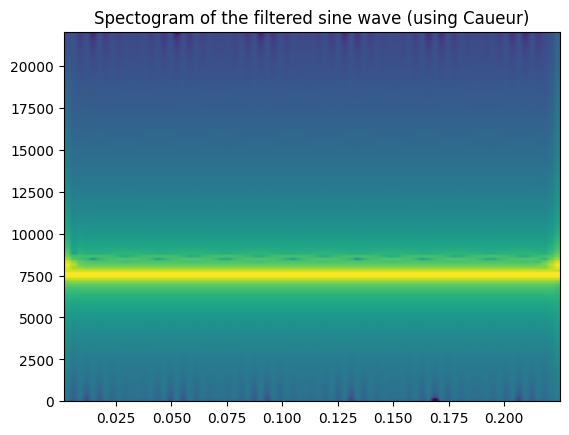

In [60]:
output_signal1 = signal.filtfilt(B_caueur, A_caueur,  sin_samples)

plot_sin(t, output_signal1, title="Filtered sine wave using a Caueur filter")

output_signal2 = signal.filtfilt(B_cheby, A_cheby,  sin_samples)


plot_sin(t, output_signal2, title="Filtered sine wave using a Chebychev filter")
x = plt.specgram(normalise(output_signal1), Fs=f)
plt.title("Spectogram of the filtered sine wave (using Caueur)")

#### 1.3.2.2. Decimation

In [61]:
def decimation(data, M=3):
    return data[::M]

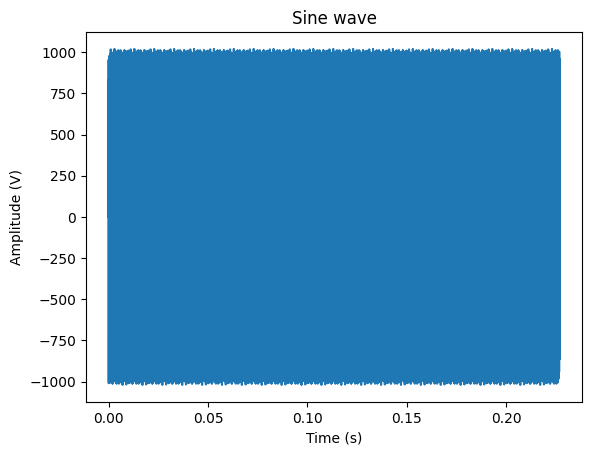

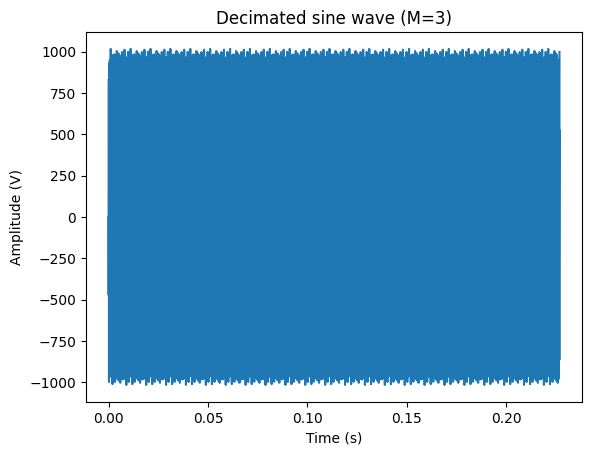

In [62]:
plot_sin(t, sin_samples)
plot_sin(t[::3], decimation(sin_samples,3), title="Decimated sine wave (M=3)")

In [63]:
def plot_freq_domain(data, multiple_list: bool = False, labels = [], fs= fs_audio, title=None):
    datas_freq = []
    f = 0
    if multiple_list:
        for data_l in data:
            f, tmp = signal.freqz(data_l, fs=fs)
            datas_freq.append(tmp)
    else:
        f, tmp = signal.freqz(data, fs=fs)
        datas_freq = [tmp]

    data_log = []
    for data_l in datas_freq:
        data_log.append(20*np.log10(np.abs(data_l)))

    simple_plot(data_log, f, "Frequency domain" if title == None else title, "freq (Hz)", "Amplitude (dB)", labels=labels)

Show frequency domain after decimation 

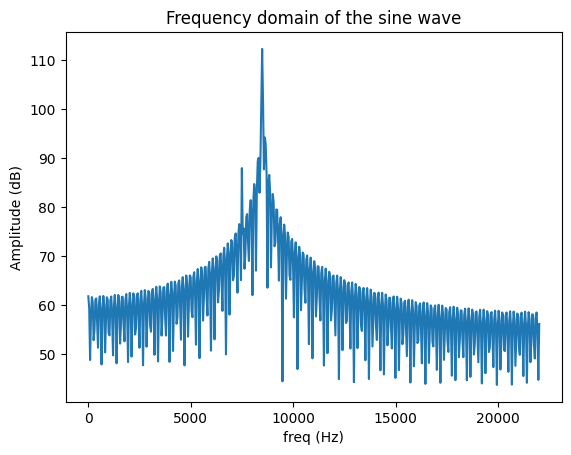

22050.0


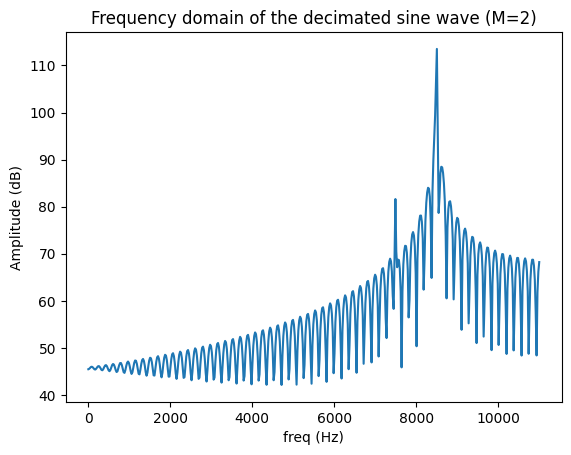

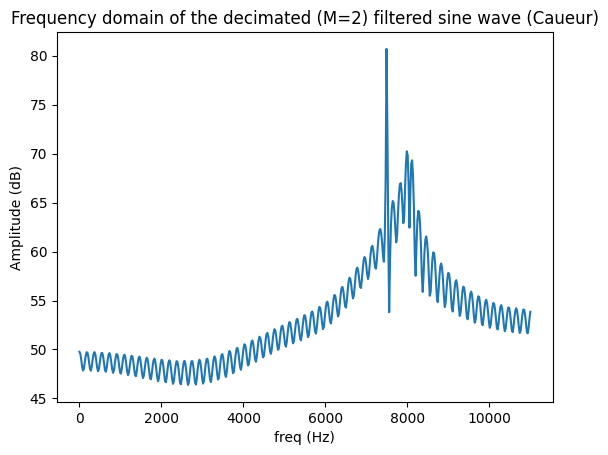

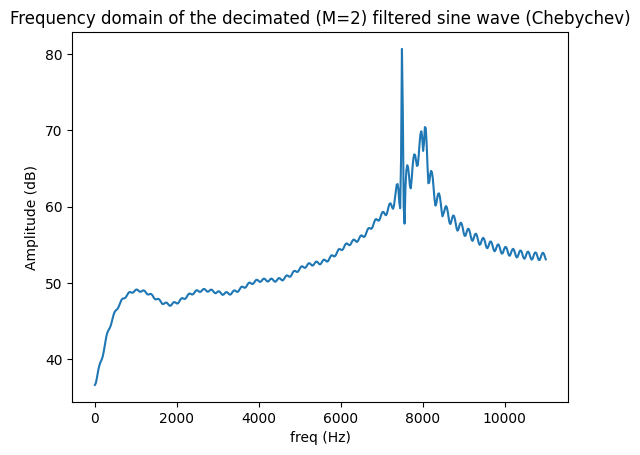

14700.0


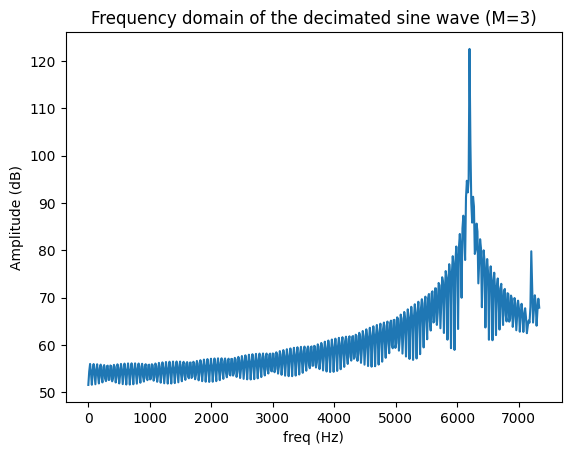

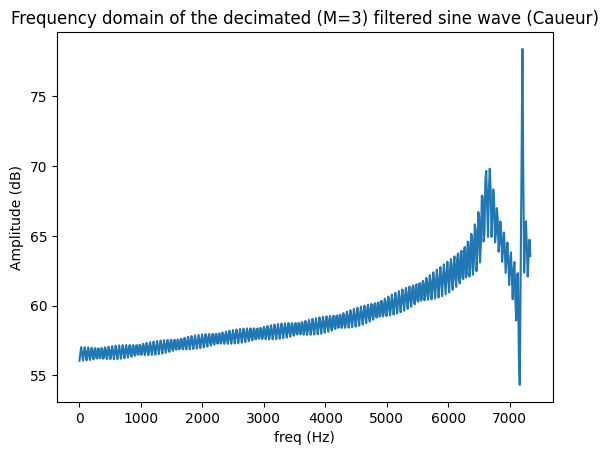

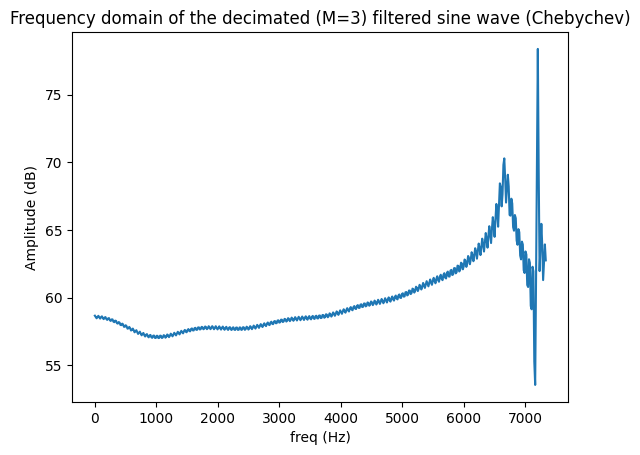

In [64]:
plot_freq_domain(sin_samples, title="Frequency domain of the sine wave")


M = [2,3]

for m in M:
    fs_new = 44100/m
    print(fs_new)

    plot_freq_domain(decimation(sin_samples, m),fs=fs_new, title=f"Frequency domain of the decimated sine wave (M={m})")


    plot_freq_domain(decimation(signal.filtfilt(B_caueur, A_caueur,  sin_samples), m), fs=fs_new, title=f"Frequency domain of the decimated (M={m}) filtered sine wave (Caueur)")
    plot_freq_domain(decimation(signal.filtfilt(B_cheby, A_cheby,  sin_samples), m), fs=fs_new, title=f"Frequency domain of the decimated (M={m}) filtered sine wave (Chebychev)")

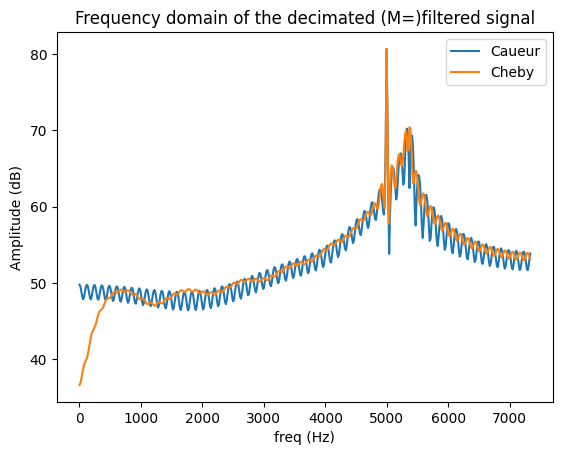

In [65]:
m = 2

plot_freq_domain([decimation(output_signal1, m),
                  decimation(output_signal2, m)], True, fs=fs_new, labels=["Caueur", "Cheby"], title=f"Frequency domain of the decimated (M=)filtered signal")

In [66]:
def downsampling(sig, B, A, M):

    # your code here #
    sig = signal.filtfilt(B, A, sig)
    return sig[::M]

## 1.4. Cross-correlation

In [67]:
def fftxcorr(in1, in2):
    
    n_1, n_2 = len(in1), len(in2)
    n = n_1 + n_2 - 1
    #n = np.pow(2, int(np.ceil(np.log(n)/np.log(2))))

    x = np.fft.fft(in1, n) * np.conjugate(np.fft.fft(in2, n))
    return np.fft.fftshift(np.fft.ifft(x, n))

/home/axel/GitProject/projet_signal/env/lib/python3.13/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/axel/GitProject/projet_signal/env/lib/python3.13/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


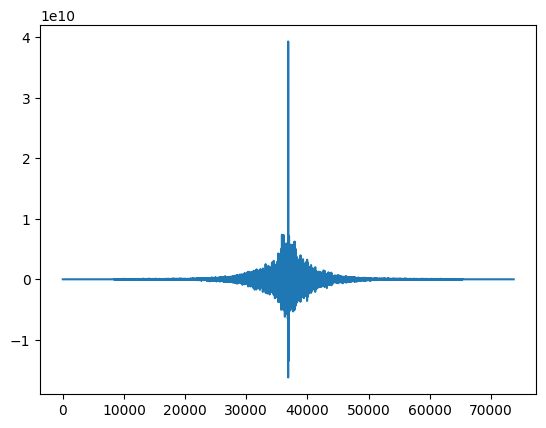

In [68]:
file_dir = "LocateClaps/"
_, data1 = read_wavefile(file_dir + "M2_0.wav")


_, data2 = read_wavefile(file_dir + "M1_0.wav")




f, sin_samples1= create_sine_wave(8500, 1000, 44100, 1000)
f, sin_samples2 = create_sine_wave(7500, 20, 44100, 1000)

y = fftxcorr(data1, data2)
simple_plot(y)

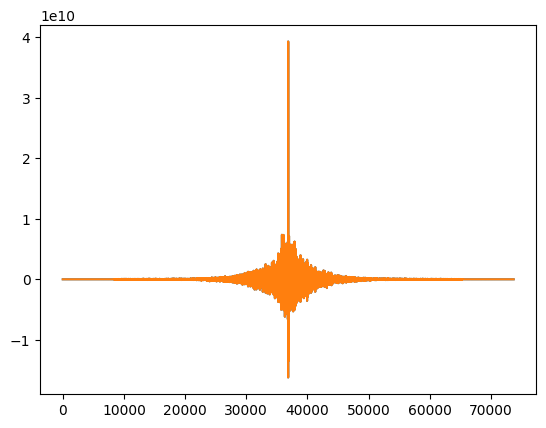

In [69]:
from scipy.signal import fftconvolve


#x = fftconvolve(data, data2, "full") # EXPLAIN IN RAPPORT
x = fftconvolve(data1, data2[::-1], "full")
plt.plot(y)

plt.plot(x)


## 1.5. Localisation

### 1.5.1. TDOA:

In [70]:
def TDOA(xcorr, fs=44.1 * 1000):
    # Get the sample index with the highest value
    (i_max, sample_max) = (-float("inf"), -float("inf"))
    for (i, sample) in enumerate(xcorr):
        if sample_max < sample:
            i_max, sample_max = i, sample
    # Get the middle
    m = len(xcorr) // 2

    return (i_max - m) / fs 


file_dir = "LocateClaps/"

_, data1 = read_wavefile(file_dir + "M2_0.wav")


_, data2 = read_wavefile(file_dir + "M1_0.wav")



TDOA(y)

-0.00011337868480725624

### 1.5.2 Sound localization system

In [71]:
from scipy.optimize import root

# mic coordinates in meters

MICS = [{'x': 0, 'y': 0.0487}, {'x': 0.0425, 'y': -0.025}, {'x': -0.0425, 'y': -0.025}] 

def equations(p, deltas):
    v = 343
    x, y = p
    alpha = np.arctan2((MICS[1]['y'] - MICS[0]['y']), (MICS[1]['x'] - MICS[0]['x']))
    beta = np.arctan2((MICS[2]['y'] - MICS[0]['y']), (MICS[2]['x'] - MICS[0]['x']))
    
    eq1 = v*deltas[0] - (np.sqrt((MICS[1]['x'] - MICS[0]['x'])**2 + (MICS[1]['y'] - MICS[0]['y'])**2) * np.sqrt((x)**2 + (y)**2) * np.cos(alpha-np.arctan2(y, x)))
    eq2 = v*deltas[1] - (np.sqrt((MICS[2]['x'] - MICS[0]['x'])**2 + (MICS[2]['y'] - MICS[0]['y'])**2) * np.sqrt((x)**2 + (y)**2) * np.cos(beta-np.arctan2(y, x)))
    return (eq1, eq2)
    
def localize_sound(deltas):
    sol = root(equations, [0, 0], (deltas), tol=10)
    return sol.x

def source_angle(coordinates):
    XS, YS = coordinates
    out = np.arctan2(YS, XS)* 180/np.pi
    # print("=> ",coordinates, " | o: ", out )
    if out < 0:
        out += 360
    return out 

In [72]:

file_dir = "LocateClaps/"
file_extension = ".wav"
real_angles = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]


for real_angle in real_angles:
    data1 = read_wavefile(file_dir + "M1_" + str(real_angle) + file_extension)[1]
    data2 = read_wavefile(file_dir + "M2_" + str(real_angle) + file_extension)[1]
    data3 = read_wavefile(file_dir + "M3_" + str(real_angle) + file_extension)[1]


    
    d1 = TDOA(fftxcorr(data1, data2))
    d2 = TDOA(fftxcorr(data1, data3))
    #print(f"=== D1: {d1}  | D2: {d2}")
    S = localize_sound([d1, d2])
    print(f"Real angle: ({real_angle}) | Computed angle: ({source_angle(S)})")

Real angle: (0) | Computed angle: (0.0)
Real angle: (30) | Computed angle: (29.970421179794062)
Real angle: (60) | Computed angle: (59.97040343760042)
Real angle: (90) | Computed angle: (84.17557978606705)
Real angle: (120) | Computed angle: (120.02959656239959)
Real angle: (150) | Computed angle: (150.02957882020596)
Real angle: (180) | Computed angle: (180.0)
Real angle: (210) | Computed angle: (209.97042117979407)
Real angle: (240) | Computed angle: (239.9704034376004)
Real angle: (270) | Computed angle: (270.0)
Real angle: (300) | Computed angle: (300.0295965623996)
Real angle: (330) | Computed angle: (324.214893078145)


## 1.6 Systems accuracy and Speed

### 1.6.1. Accuracy

In [73]:
from time import time_ns

def accuracy(pred_angle, gt_angle, threshold):
    return abs(pred_angle - gt_angle) < threshold

In [74]:
def preprocessing(data):
    # Normalisation
    data = normalise(data)

    # Downsampling

    (B_caueur, A_caueur) = create_filter_cauer(wp, ws,  rp, rs, fs_audio)
    return downsampling(data, B_caueur, A_caueur, 3)

def print_accuracy(prepocess_data: bool):
    threshold = 5
    true_count = 0
    angle_count = 0
    print("Threshhold:", threshold)
    print("_"*10)
    for real_angle in real_angles:
        data1 = read_wavefile(file_dir + "M1_" + str(real_angle) + file_extension)[1]
        data2 = read_wavefile(file_dir + "M2_" + str(real_angle) + file_extension)[1]
        data3 = read_wavefile(file_dir + "M3_" + str(real_angle) + file_extension)[1]

        if prepocess_data:
            data1 = preprocessing(data1)
            data2 = preprocessing(data2)
            data3 = preprocessing(data3)
        
        d1 = TDOA(fftxcorr(data1, data2))
        d2 = TDOA(fftxcorr(data1, data3))
        #print(f"=== D1: {d1}  | D2: {d2}")
        S = localize_sound([d1, d2])
        pred = source_angle(S)
        
        is_accurate = accuracy(pred, real_angle, 1)
        if is_accurate:
            true_count += 1
        print(f"Real angle: ({real_angle}) | Computed angle: ({source_angle(S)})")
        print("\t",accuracy(pred, real_angle, 1))
        angle_count += 1

    print("_"*10)

    print("Average accuracy: ", true_count/angle_count)

In [75]:
print_accuracy(False)

Threshhold: 5
__________
Real angle: (0) | Computed angle: (0.0)
	 True
Real angle: (30) | Computed angle: (29.970421179794062)
	 True
Real angle: (60) | Computed angle: (59.97040343760042)
	 True
Real angle: (90) | Computed angle: (84.17557978606705)
	 False
Real angle: (120) | Computed angle: (120.02959656239959)
	 True
Real angle: (150) | Computed angle: (150.02957882020596)
	 True
Real angle: (180) | Computed angle: (180.0)
	 True
Real angle: (210) | Computed angle: (209.97042117979407)
	 True
Real angle: (240) | Computed angle: (239.9704034376004)
	 True
Real angle: (270) | Computed angle: (270.0)
	 True
Real angle: (300) | Computed angle: (300.0295965623996)
	 True
Real angle: (330) | Computed angle: (324.214893078145)
	 False
__________
Average accuracy:  0.8333333333333334


In [76]:
print_accuracy(True) # Quicker but less accurate

Threshhold: 5
__________
Real angle: (0) | Computed angle: (5.210792772829357e-15)
	 True
Real angle: (30) | Computed angle: (29.970421179794055)
	 True
Real angle: (60) | Computed angle: (70.8722507744857)
	 False
Real angle: (90) | Computed angle: (90.00000000000001)
	 True
Real angle: (120) | Computed angle: (109.12774922551431)
	 False
Real angle: (150) | Computed angle: (150.02957882020596)
	 True
Real angle: (180) | Computed angle: (180.0)
	 True
Real angle: (210) | Computed angle: (209.97042117979404)
	 True
Real angle: (240) | Computed angle: (250.87225077448568)
	 False
Real angle: (270) | Computed angle: (270.0)
	 True
Real angle: (300) | Computed angle: (289.1277492255143)
	 False
Real angle: (330) | Computed angle: (330.0295788202059)
	 True
__________
Average accuracy:  0.6666666666666666


### 1.6.2. Speed

In [77]:
from time import time_ns, sleep

def func_example(a, b):
    return a*b

def time_delay(func, args):
    start_time = time_ns()
    out = func(*args)
    end_time = time_ns()
    print(f"{func.__name__} in {end_time - start_time} ns")
    return out

product = time_delay(func_example, [2, 10])

func_example in 1112 ns


In [82]:
# Using downsampling
_, data1 = read_wavefile(file_dir + "M1_120.wav")
_, data2 = read_wavefile(file_dir + "M2_120.wav")
_, data3 = read_wavefile(file_dir + "M3_120.wav")

print("With downsampling: ")

# Normalisation
data1 = time_delay(normalise,[data1])

# Downsampling

## Filter

data1 = time_delay(downsampling, [data1, B_caueur, A_caueur, 3])

corr_1 = time_delay(fftxcorr, [data1, data2])
corr_2 = fftxcorr(data1, data3)

corr_1 = time_delay(fftconvolve, [data1, data2[::-1], "full"])
corr_2 = fftxcorr(data1, data3)

d1 = time_delay(TDOA, [corr_1])
d2 = TDOA(corr_2)

S = time_delay(localize_sound, [[d1, d2]])

o = time_delay(source_angle,[S])

With downsampling: 
normalise in 2927313 ns
downsampling in 1100992 ns
fftxcorr in 28791909 ns
fftconvolve in 2098198 ns
TDOA in 5108369 ns
localize_sound in 338764 ns
source_angle in 11001 ns


In [83]:
# Using downsampling
_, data1 = read_wavefile(file_dir + "M1_120.wav")
_, data2 = read_wavefile(file_dir + "M2_120.wav")
_, data3 = read_wavefile(file_dir + "M3_120.wav")

print("Without downsampling: ")

# Normalisation
data1 = time_delay(normalise,[data1])

# Downsampling

## Filter

corr_1 = time_delay(fftxcorr, [data1, data2])
corr_2 = fftxcorr(data1, data3)

corr_1 = time_delay(fftconvolve, [data1, data2[::-1], "full"])
corr_2 = fftxcorr(data1, data3)

d1 = time_delay(TDOA, [corr_1])
d2 = TDOA(corr_2)

S = time_delay(localize_sound, [[d1, d2]])

o = time_delay(source_angle,[S])

Without downsampling: 
normalise in 3057000 ns
fftxcorr in 52389817 ns
fftconvolve in 3400181 ns
TDOA in 7569817 ns
localize_sound in 248663 ns
source_angle in 8426 ns
